## **Mô hình K-MEANS phân cụm lợi nhuận theo loại sản phẩm**

### **Bước 1: Load bộ dữ liệu**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType


spark = SparkSession.builder.appName("KMeansClusteringProfit_Product").getOrCreate()


df = spark.read.csv("D:/Downloads/DataCo_Cleaned/DataCo_Cleaned/Dataclean.csv", header=True, inferSchema=True)


# Giữ lại các cột cần thiết và drop NA
df = df.select("Order Id", "Order Profit Per Order", "Category Name").dropna()


# Chuyển cột profit sang float (nếu chưa phải)
df = df.withColumn("Order Profit Per Order", col("Order Profit Per Order").cast(FloatType()))


df.show(5)

+--------+----------------------+--------------+
|Order Id|Order Profit Per Order| Category Name|
+--------+----------------------+--------------+
|   77202|                 91.25|Sporting Goods|
|   75939|               -249.09|Sporting Goods|
|   75938|               -247.78|Sporting Goods|
|   75937|                 22.86|Sporting Goods|
|   75936|                134.21|Sporting Goods|
+--------+----------------------+--------------+
only showing top 5 rows



### **Bước 2: Chuyển đổi dữ liệu**

In [2]:
from pyspark.ml.feature import VectorAssembler, StandardScaler


assembler = VectorAssembler(inputCols=["Order Profit Per Order"], outputCol="profit_vec")
df_vec = assembler.transform(df)


scaler = StandardScaler(inputCol="profit_vec", outputCol="scaled_profit", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)


### **Bước 3: Vẽ biểu đồ elbow**

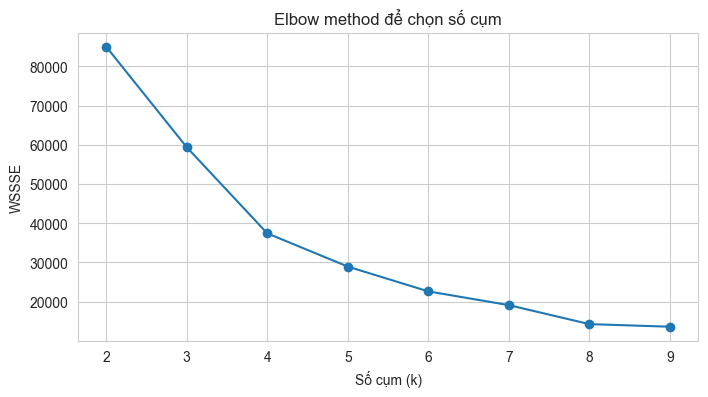

In [3]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt


cost = []
k_values = list(range(2, 10))


for k in k_values:
   kmeans = KMeans(featuresCol='scaled_profit', k=k, seed=42)
   model = kmeans.fit(df_scaled)
   wssse = model.summary.trainingCost
   cost.append(wssse)


plt.figure(figsize=(8,4))
plt.plot(k_values, cost, marker='o')
plt.xlabel('Số cụm (k)')
plt.ylabel('WSSSE')
plt.title('Elbow method để chọn số cụm')
plt.grid(True)
plt.show()

### **Bước 4: Mô hình k-means**

In [4]:
kmeans = KMeans(featuresCol='scaled_profit', k=3, seed=42)
model = kmeans.fit(df_scaled)
df_clustered = model.transform(df_scaled)
df_clustered.show(5)

+--------+----------------------+--------------+--------------------+--------------------+----------+
|Order Id|Order Profit Per Order| Category Name|          profit_vec|       scaled_profit|prediction|
+--------+----------------------+--------------+--------------------+--------------------+----------+
|   77202|                 91.25|Sporting Goods|             [91.25]|[0.6633714094161608]|         0|
|   75939|               -249.09|Sporting Goods|[-249.08999633789...|[-2.5955332854549...|         2|
|   75938|               -247.78|Sporting Goods|[-247.77999877929...|[-2.5829894844327...|         2|
|   75937|                 22.86|Sporting Goods|[22.860000610351562]|[0.00850717808471...|         0|
|   75936|                134.21|Sporting Goods| [134.2100067138672]|[1.0747323105090834]|         0|
+--------+----------------------+--------------+--------------------+--------------------+----------+
only showing top 5 rows



### **Bước 5: Phân cụm theo mean_profit**

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, create_map, lit
from itertools import chain


# 1. Lấy danh sách cluster theo thứ tự mean_profit giảm dần
mean_profit = df_clustered.groupBy("prediction") \
   .agg(F.mean("Order Profit Per Order").alias("mean_profit")) \
   .orderBy(F.desc("mean_profit"))


cluster_order = [row['prediction'] for row in mean_profit.collect()]
cluster_map = {old: new for new, old in enumerate(cluster_order)}


# 2. Tạo map dưới dạng dict (old -> new)
mapping_expr = create_map([lit(x) for x in chain(*cluster_map.items())])


# 3. Áp map trực tiếp trong withColumn, không dùng UDF
df_final = df_clustered.withColumn("Profit Cluster", mapping_expr[col("prediction")])


df_final.select("Order Id", "Order Profit Per Order", "Profit Cluster", "Category Name").show(5)

+--------+----------------------+--------------+--------------+
|Order Id|Order Profit Per Order|Profit Cluster| Category Name|
+--------+----------------------+--------------+--------------+
|   77202|                 91.25|             0|Sporting Goods|
|   75939|               -249.09|             1|Sporting Goods|
|   75938|               -247.78|             1|Sporting Goods|
|   75937|                 22.86|             0|Sporting Goods|
|   75936|                134.21|             0|Sporting Goods|
+--------+----------------------+--------------+--------------+
only showing top 5 rows



### **Bước 6: Thống kê**

In [6]:
from pyspark.sql import functions as F


df_final.groupBy("Profit Cluster") \
   .agg(
       F.count("*").alias("count"),
       F.mean("Order Profit Per Order").alias("mean"),
       F.stddev("Order Profit Per Order").alias("stddev"),
       F.min("Order Profit Per Order").alias("min"),
       F.expr("percentile_approx(`Order Profit Per Order`, 0.25)").alias("25%"),
       F.expr("percentile_approx(`Order Profit Per Order`, 0.5)").alias("50%"),
       F.expr("percentile_approx(`Order Profit Per Order`, 0.75)").alias("75%"),
       F.max("Order Profit Per Order").alias("max")
   ).show()

+--------------+------+-------------------+------------------+--------+-------+-------+-------+-------+
|Profit Cluster| count|               mean|            stddev|     min|    25%|    50%|    75%|    max|
+--------------+------+-------------------+------------------+--------+-------+-------+-------+-------+
|             1| 15988|-142.73248314374322|  79.8646291561909|  -354.9|-195.57|-119.92|  -75.6| -48.15|
|             2|  2276| -567.2159161961561|252.76175218109518|-4274.98|-630.87| -504.4|-427.47|-355.47|
|             0|162244|  46.46725481219288| 49.66615030833563|  -48.09|  13.66|  37.22|  70.12|  911.8|
+--------------+------+-------------------+------------------+--------+-------+-------+-------+-------+



In [7]:
df_final.groupBy("Profit Cluster", "Category Name").count() \
   .orderBy("Profit Cluster", "Category Name") \
   .show(truncate=False)

+--------------+--------------------+-----+
|Profit Cluster|Category Name       |count|
+--------------+--------------------+-----+
|0             |Accessories         |1686 |
|0             |As Seen on  TV!     |56   |
|0             |Baby                |201  |
|0             |Baseball & Softball |579  |
|0             |Basketball          |56   |
|0             |Books               |394  |
|0             |Boxing & MMA        |374  |
|0             |CDs                 |271  |
|0             |Cameras             |506  |
|0             |Camping & Hiking    |11824|
|0             |Cardio Equipment    |10940|
|0             |Children's Clothing |550  |
|0             |Cleats              |22237|
|0             |Computers           |372  |
|0             |Consumer Electronics|383  |
|0             |Crafts              |408  |
|0             |DVDs                |429  |
|0             |Electronics         |2913 |
|0             |Fishing             |14772|
|0             |Fitness Accessor

### **Bước 7: Vẽ biểu đồ phân cụm**

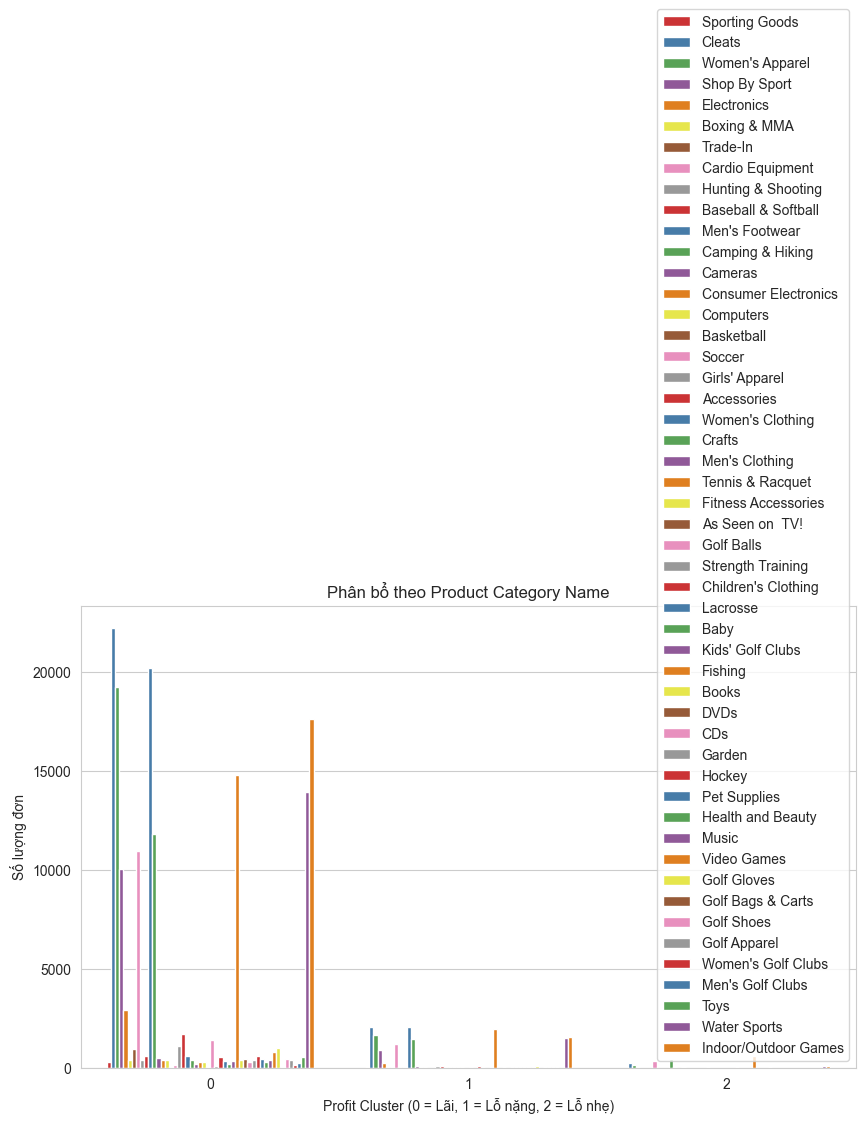

In [8]:
import seaborn as sns

pdf = df_final.select("Profit Cluster", "Category Name").toPandas()

plt.figure(figsize=(10,6))
sns.countplot(data=pdf, x='Profit Cluster', hue='Category Name', palette='Set1')
plt.xlabel('Profit Cluster (0 = Lãi, 1 = Lỗ nặng, 2 = Lỗ nhẹ)')
plt.ylabel('Số lượng đơn')
plt.title('Phân bổ theo Product Category Name')
plt.legend(title=None)
plt.show()

### **Bước 8: Phân cụm lợi nhuận theo top 5 loại sản phẩm**

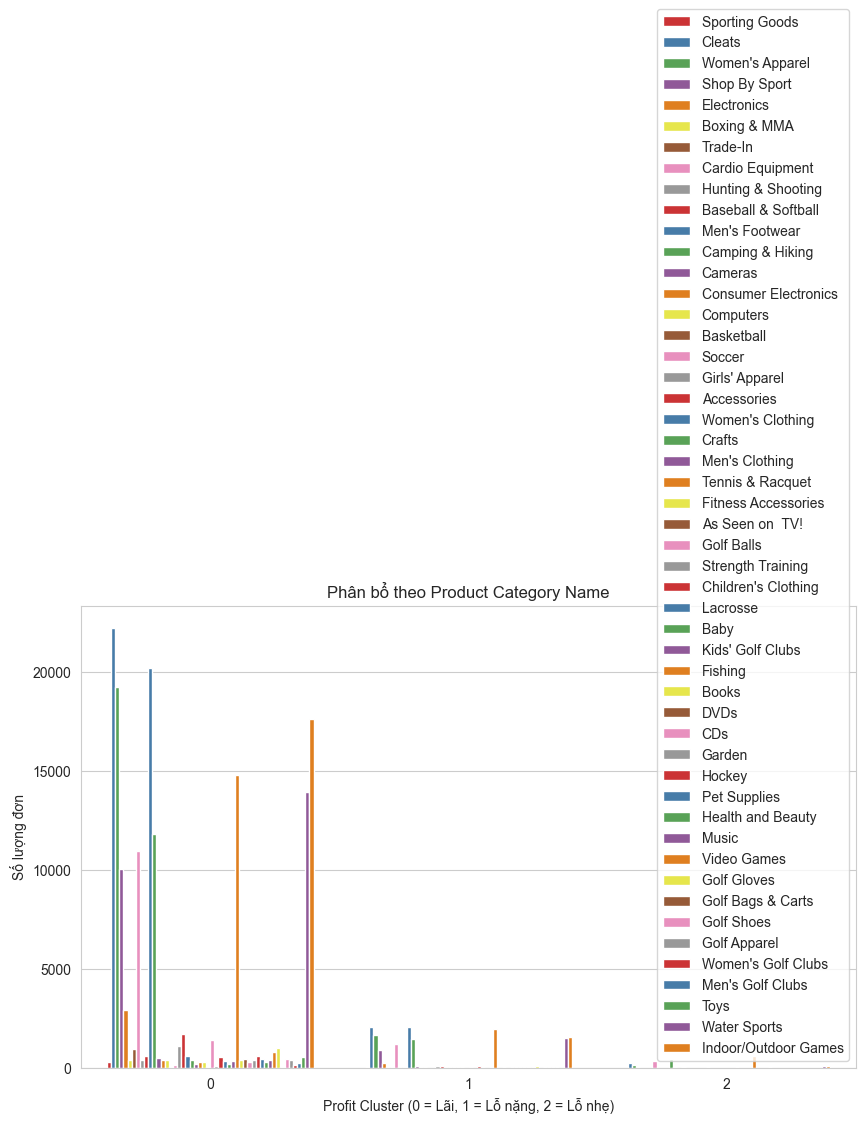

In [9]:
import seaborn as sns

pdf = df_final.select("Profit Cluster", "Category Name").toPandas()

plt.figure(figsize=(10,6))
sns.countplot(data=pdf, x='Profit Cluster', hue='Category Name', palette='Set1')
plt.xlabel('Profit Cluster (0 = Lãi, 1 = Lỗ nặng, 2 = Lỗ nhẹ)')
plt.ylabel('Số lượng đơn')
plt.title('Phân bổ theo Product Category Name')
plt.legend(title=None)
plt.show()


C:\Users\nny08\AppData\Local\Temp\ipykernel_30172\964290061.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index.astype(str), y=data.values, palette='Set1')


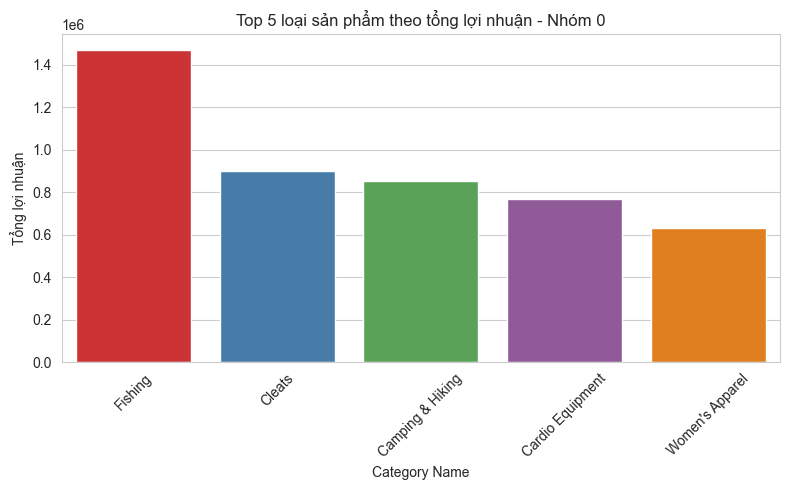

C:\Users\nny08\AppData\Local\Temp\ipykernel_30172\964290061.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index.astype(str), y=data.values, palette='Set1')


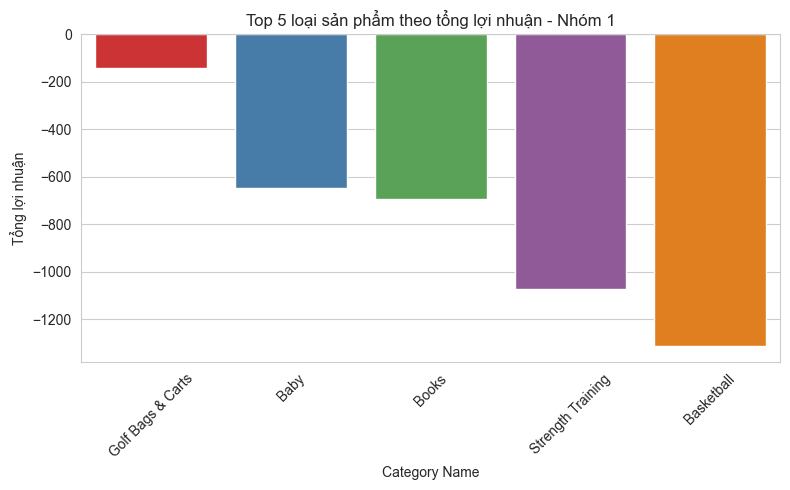

C:\Users\nny08\AppData\Local\Temp\ipykernel_30172\964290061.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index.astype(str), y=data.values, palette='Set1')


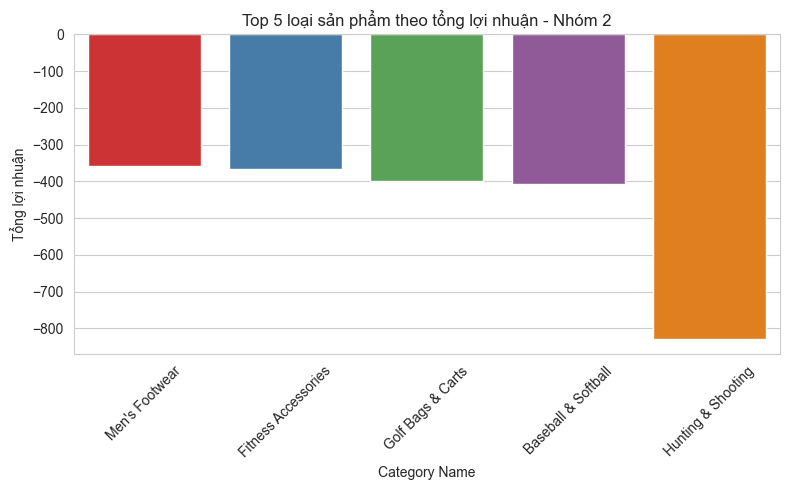

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển sang pandas
pdf = df_final.select("Category Name", "Profit Cluster", "Order Profit Per Order").toPandas()

def get_top_n_by_profit(df, group_col, cluster_col, profit_col, n=5):
    top_products = {}
    for cluster in df[cluster_col].unique():  # Bây giờ df là pandas nên .unique() OK
        subset = df[df[cluster_col] == cluster]
        top_n = subset.groupby(group_col)[profit_col].sum().nlargest(n)
        top_products[cluster] = top_n
    return top_products

# Gọi hàm với pandas dataframe
top_products_high = get_top_n_by_profit(pdf, 'Category Name', 'Profit Cluster', 'Order Profit Per Order', n=5)

# Vẽ biểu đồ cho từng cluster
for cluster, data in top_products_high.items():
   plt.figure(figsize=(8,5))
   sns.barplot(x=data.index.astype(str), y=data.values, palette='Set1')
   plt.title(f'Top 5 loại sản phẩm theo tổng lợi nhuận - Nhóm {cluster}')
   plt.xlabel('Category Name')
   plt.ylabel('Tổng lợi nhuận')
   plt.xticks(rotation=45)
   plt.tight_layout()
   plt.show()

### **Bước 9: Số lượng đơn đặt hàng theo mỗi cụm**

C:\Users\nny08\AppData\Local\Temp\ipykernel_30172\2372286012.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pdf, x='Profit Cluster', palette='Set2')  # palette bạn có thể đổi tùy thích


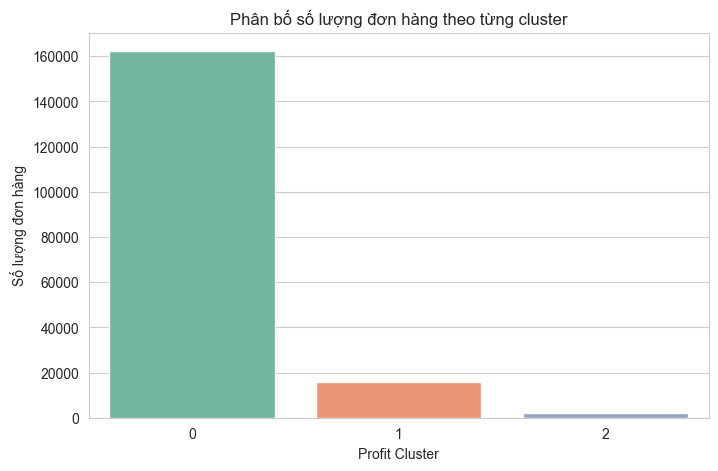

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


# Chuyển dataframe PySpark sang pandas
pdf = df_final.select("Profit Cluster").toPandas()


plt.figure(figsize=(8,5))
sns.countplot(data=pdf, x='Profit Cluster', palette='Set2')  # palette bạn có thể đổi tùy thích
plt.title('Phân bố số lượng đơn hàng theo từng cluster')
plt.xlabel('Profit Cluster')
plt.ylabel('Số lượng đơn hàng')
plt.show()

### **Bước 10: Tổng lợi nhuận theo cụm**

In [15]:
# Chuyển sang pandas để thao tác groupby, reset_index dễ dàng
pdf = df_final.select("Profit Cluster", "Order Profit Per Order").toPandas()


# Tổng lợi nhuận theo cluster
profit_by_cluster = pdf.groupby('Profit Cluster')['Order Profit Per Order'].sum().reset_index()
print(profit_by_cluster)

   Profit Cluster  Order Profit Per Order
0               0             7539033.500
1               1            -2282007.000
2               2            -1290983.375
